In [3]:
import spreg
from spreg import OLS
from spreg import ML_Lag, ML_Lag_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import robust_scale
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate

In [13]:
db = libpysal.io.open('../raw_data/basic_model_preds_gdf.dbf','r')
df = gpd.read_file('../raw_data/basic_model_preds_gdf.shp')

In [14]:
df.columns

Index(['PLR_ID', 'public_tra', 'eating', 'culture', 'community', 'health_car',
       'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
       'night_life', 'water', 'mig_rate', 'ave_rent', 'social_hou',
       'public_hou', 'five_y_pls', 'child_pov', 'dyn_unempl', 'air', 'bio',
       'vegpm20', 'ch_rate', 'other_sch', 'vocat_sch', 'primary_sc',
       'Gymnasium', 'secon_sch', 'priv_schoo', 'kita', 'stations', 'geometry'],
      dtype='object')

In [15]:
columns = [
        'public_tra', 'eating', 'culture', 'community', 'health_car',
        'public_ser', 'education', 'universiti', 'outdoor_fa', 'outdoor_le',
        'night_life', 'water', 'mig_rate', 'ave_rent', 'social_hou',
        'public_hou', 'five_y_pls', 'dyn_unempl', 'air', 'bio',
        'vegpm20', 'ch_rate', 'other_sch', 'vocat_sch', 'primary_sc',
        'Gymnasium', 'secon_sch', 'priv_schoo', 'kita', 'stations'
]
#regimes = db.by_col("label")

In [16]:
y = np.array(db.by_col('child_pov')).T
x_names = columns
X = np.array([db.by_col(var) for var in x_names]).T

In [17]:
queen = libpysal.weights.Queen.from_dataframe(df)

In [32]:
inv_dist = libpysal.weights.DistanceBand.from_dataframe(df, 5100, geom_col='geometry', binary=False)

In [54]:
rook = libpysal.weights.Rook.from_dataframe(df)

In [24]:
mllag = ML_Lag(y,
                   X,
                   name_x=columns,
                   name_y='child poverty',
                   w=queen,
                   name_ds='infra_df',
                   name_w='inv_dist')

In [25]:
print(mllag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :    infra_df
Weights matrix      :    inv_dist
Dependent Variable  :child poverty                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          32
S.D. dependent var  :     16.6701                Degrees of Freedom    :         504
Pseudo R-squared    :      0.7918
Spatial Pseudo R-squared:  0.7865
Sigma-square ML     :      57.746                Log likelihood        :   -1847.957
S.E of regression   :       7.599                Akaike info criterion :    3759.913
                                                 Schwarz criterion     :    3897.006

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------

In [26]:
mae(df.child_pov, mllag.u)

24.557065863655396

In [27]:
mse(df.child_pov, mllag.u)

821.7008733512909

<AxesSubplot:>

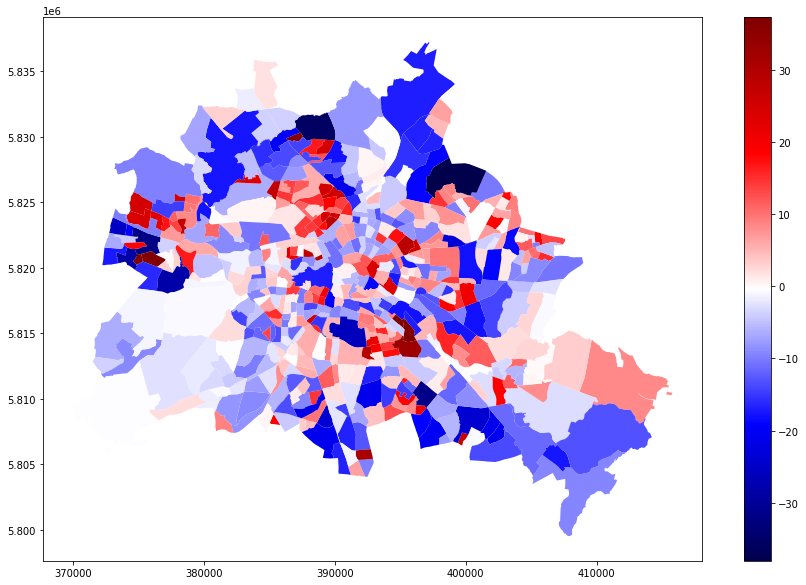

In [85]:
# Adding a resituals column to sample dataframe
df['residuals_mllag'] = mlerror.u

# plotting residuals - red = underestimation, blue = overestimation
df.plot('residuals_mllag', figsize=(15,10), cmap= 'seismic', legend=True)

In [28]:
west = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_West_EPSG54030.shp')
east = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_Ost_EPSG54030.shp')

east.to_crs(crs='EPSG:25833', inplace=True)

west.to_crs(crs='EPSG:25833', inplace=True)

west = west.dissolve()

east = east.dissolve()

eastwest = east.append(west)

eastwest['east'] = eastwest.OBJECTID.map({1:1,
                                             2:0})

df_east = df.sjoin_nearest(
    eastwest, how='left').dissolve(
    by='PLR_ID')

df = df.merge(df_east.reset_index()[['PLR_ID','east']], on='PLR_ID')

/var/folders/sx/4s_zvfwj1xddph7py3s74ych0000gn/T/ipykernel_23982/4049039317.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eastwest = east.append(west)


In [35]:
mllag_regimes = ML_Lag_Regimes(y,
                   X,
                    regimes=df['east'],
                   name_x=columns,
                   name_y='child poverty',
                   w=queen,
                   name_ds='selected_ds',
                   name_w='inv_dist')

In [36]:
print(mllag_regimes.summary) # only significant difference in the coefficients is in green volume

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG - REGIMES (METHOD = full)
---------------------------------------------------------------------------
Data set            : selected_ds
Weights matrix      :    inv_dist
Dependent Variable  :child poverty                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          63
S.D. dependent var  :     16.6701                Degrees of Freedom    :         473
Pseudo R-squared    :      0.8077
Spatial Pseudo R-squared:  0.8055
Sigma-square ML     :      53.341                Log likelihood        :   -1826.513
S.E of regression   :       7.303                Akaike info criterion :    3779.026
                                                 Schwarz criterion     :    4048.927

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------

In [37]:
mae(df.child_pov, mllag_regimes.u)

24.596710023079698

In [38]:
mse(df.child_pov, mllag_regimes.u)

826.1907649185887

<AxesSubplot:>

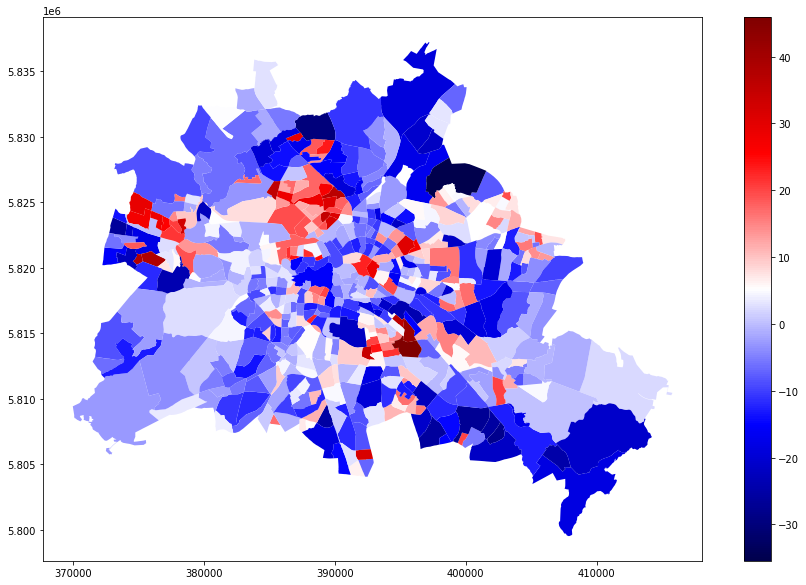

In [84]:
# Adding a resituals column to sample dataframe
df['residuals_mllag_res'] = mlerror_regimes.u

# plotting residuals - red = underestimation, blue = overestimation
df.plot('residuals_mllag_res', figsize=(15,10), cmap= 'seismic', legend=True)